In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

from datetime import datetime, timedelta

#import lightgbm as lgb

import warnings # Supress warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('train_data.csv')
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('test_data.csv')
display(test_df.head().style.set_caption('Test data'))

submit = pd.read_csv('sample_solution.csv')

target ='contest-tmp2m-14d__tmp2m'

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

In [3]:
#change startdate to datetime format for easier handling.
train_df.startdate = pd.to_datetime(train_df.startdate)
test_df.startdate = pd.to_datetime(test_df.startdate)

EDA
NOTE. Based on discussion on Kaggle, there are 514 unique locations in the data and test sets.

In [4]:
#create a location feature from the lat/lon coordinates.

# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,-8.49,32.39,38.82,7.42,11.75,-23.62,-0.24,-5.94,51.23,574
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,0.83,26.23,37.64,13.01,17.84,-22.05,-3.03,1.31,51.45,574
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,10.90,21.06,36.53,14.15,23.12,-25.60,-5.88,9.32,45.32,574
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,21.37,20.42,36.05,6.38,29.00,-27.06,-1.42,16.06,31.88,574


575 unique locations


In [5]:
# We have different locations, between training and test data.
# Flavia Felicioni has investigated this issue in her notebook WiDS 2023: different locations train/test SOLVED and found that this issue is caused due to rounding differences between training and test data.

scale = 14

train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,-8.49,32.39,38.82,7.42,11.75,-23.62,-0.24,-5.94,51.23,513
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,0.83,26.23,37.64,13.01,17.84,-22.05,-3.03,1.31,51.45,513
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,10.90,21.06,36.53,14.15,23.12,-25.60,-5.88,9.32,45.32,513
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,21.37,20.42,36.05,6.38,29.00,-27.06,-1.42,16.06,31.88,513


514 unique locations
Locations in train that are not in test
[]
Locations in test that are not in train
[]


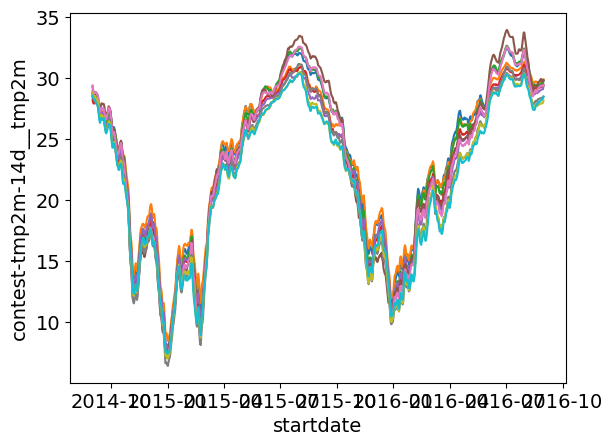

In [6]:
for i in range(10):
    temp = train_df[train_df.loc_group == i]
    sns.lineplot(data=temp, x = 'startdate', y = 'contest-tmp2m-14d__tmp2m')
#temp = train_df[train_df.loc_group == 1]
#sns.lineplot(data=temp, x = 'startdate', y = 'contest-tmp2m-14d__tmp2m')

#temp = train_df[train_df.loc_group == 2]
#sns.lineplot(data=temp, x = 'startdate', y = 'contest-tmp2m-14d__tmp2m')

From the above graph, we can see the distribution of contest-tmp2m-14d__tmp2m of different locations.

Preprocessing:
Check for missing data.

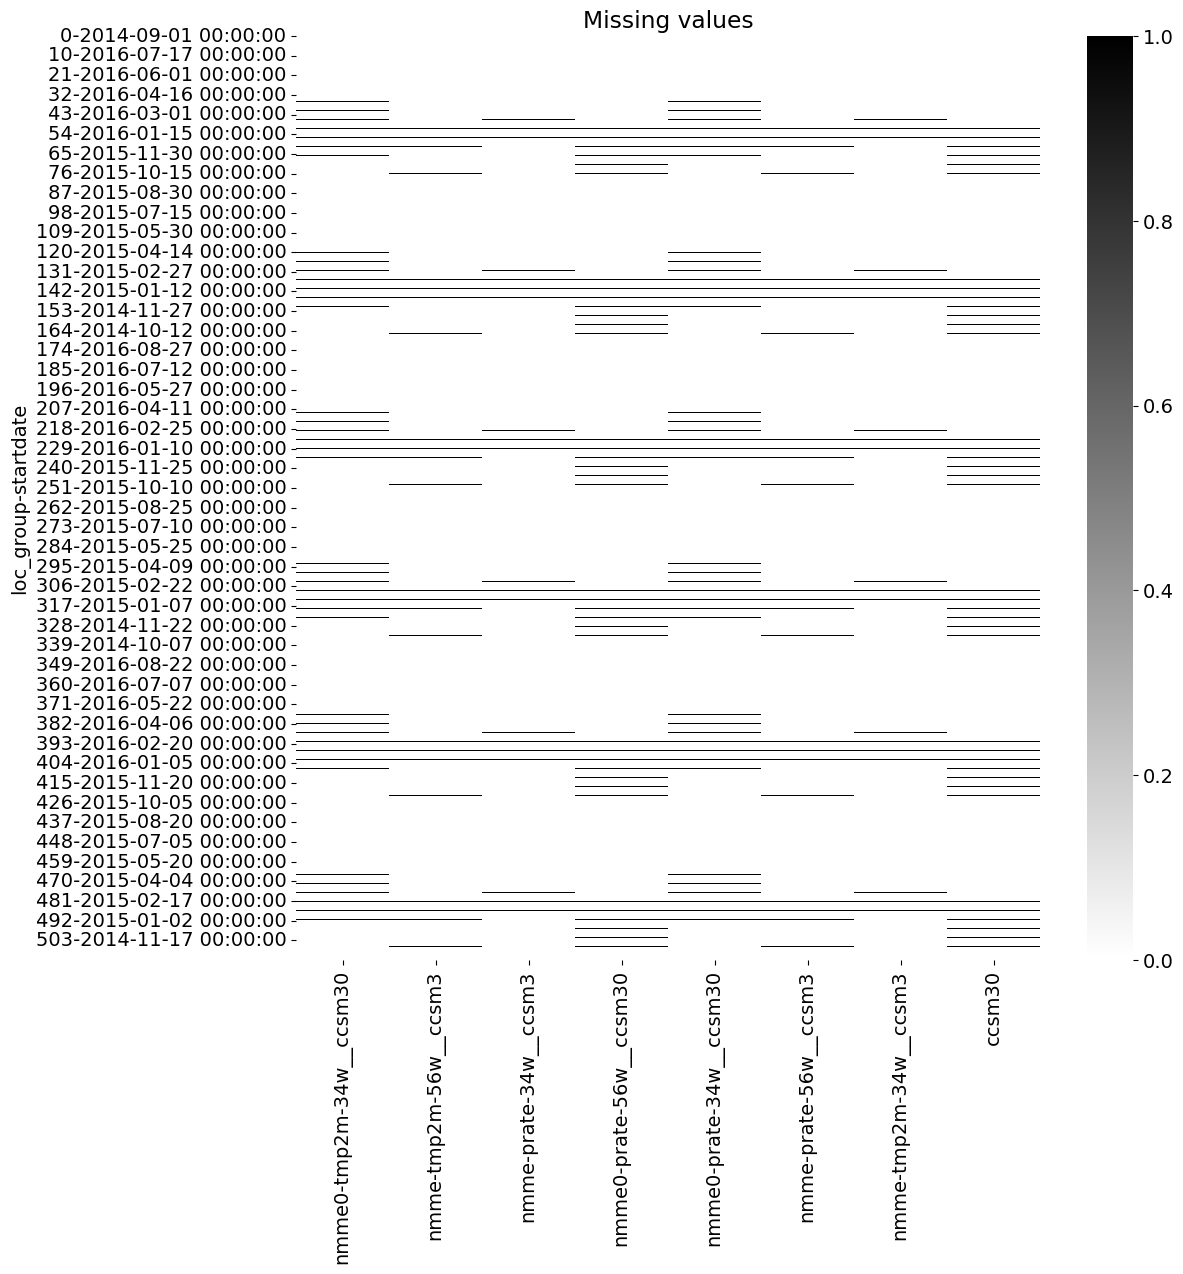

In [7]:

cols_with_missing = list(train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) > 0].index)

fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(train_df.set_index([ 'loc_group', 'startdate'])[cols_with_missing].isnull(), cmap='binary')
ax.set_title('Missing values')
plt.show()

Often times in Machine Learning, missing values are filled with the mean value. But as you can see below in pink, filling missing values with the mean value is not ideal. Our human intuition tells us that the time series values should not drop down to the mean value where the data points are missing. Instead the values should probably be filled with some value between 27 and 30.

For this purpose, we can use the .ffill() method, which just uses the last observed value to fill the missing value.

In [8]:
train_df = train_df.sort_values(by=['loc_group', 'startdate']).ffill()

Feature Engineering

In [9]:
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])

In [10]:
def create_time_features(df):
    df = df.copy()
    #df['year'] = df.startdate.dt.year
    df['quarter'] = df.startdate.dt.quarter
    df['month'] = df.startdate.dt.month
    df['week'] = df.startdate.dt.weekofyear
    df['dayofyear'] = df.startdate.dt.day_of_year
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)
train_df.head()

# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def add_season(df):
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(train_df)
add_season(test_df)

# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['week'])
    df['week_cos'] = cos_transformer(52).fit_transform(df['week'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    # encode the season with a period of 4
    df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    df['season_cos'] = cos_transformer(4).fit_transform(df['season'])
    
    # encode the quarter with a period of 4
    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

encode_cyclical(train_df)
encode_cyclical(test_df)

In [11]:
#Drop cplumns
drop_cols = ['index', 'startdate', 'lat', 'lon', target]
features = [col for col in train_df.columns if col not in drop_cols]
X = train_df[features]
X_test = test_df[features]
y = train_df[target]


Train and Validation
Based on 'Simple baseline - RMSE 1.14'

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 257)    |   Val_shape: (123993, 257)    |   Test_shape: (31354, 257)


In [13]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [14]:
model_cat = CatBoostRegressor(verbose=200)
model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_val)
print(f"RMSE: {rmse(y_val, y_pred_cat):.4f}")

Learning rate set to 0.098069
0:	learn: 9.0236750	total: 113ms	remaining: 1m 53s
200:	learn: 1.0271867	total: 7.24s	remaining: 28.8s
400:	learn: 0.7972324	total: 14s	remaining: 20.9s
600:	learn: 0.6856016	total: 20.9s	remaining: 13.9s
800:	learn: 0.6132410	total: 27.8s	remaining: 6.9s
999:	learn: 0.5615911	total: 34.7s	remaining: 0us
RMSE: 0.5791


In [20]:
import xgboost as xgb


TypeError: XGBModel.fit() missing 1 required positional argument: 'y'

In [17]:
#Add another model

model_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       tree_method = 'gpu_hist',
                       n_estimators=10000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01, gpu_id=0)
model_reg.fit(X_train, y_train)



y_pred_xgb=model_reg.predict(X_val)
print(f"RMSE: {rmse(y_val, y_pred_xgb):.4f}")

KeyboardInterrupt: 

Feature Importance

In [ ]:
import matplotlib.pyplot as plt
feature_importance = model_cat.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

Submit

In [ ]:
submit[target] = model_cat.predict(X_test)
submit.to_csv('submission.csv', index = False)